### Evaluate the model

In [1]:
from TennisStrenghtModel import TennisStrenghtModel, evaluate_accuracy_on_next_match_prediction
from DataProcessorForTennisStrenghtModel import DataProcessorForTennisStrenghtModel
from TennisPostGameScoreModel import TennisPostGameScoreModel
from sklearn.linear_model import LogisticRegression

import pickle
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data_21 = pd.read_csv('data/atp_matches_2021.csv')
data_22 = pd.read_csv('data/atp_matches_2022.csv')
data_23 = pd.read_csv('data/atp_matches_2023.csv')
data_24 = pd.read_csv('data/atp_matches_2024.csv')

In [3]:
data = pd.concat([data_21, data_22, data_23, data_24], axis=0, ignore_index=True)

In [4]:
tennis_logistic_model = TennisPostGameScoreModel()

In [5]:
data_processor = DataProcessorForTennisStrenghtModel(data)
data_processor.feature_engineering()

matches = data_processor.prepare_matches(tennis_logistic_model)

preparing inputs and target...


100%|██████████| 10719/10719 [02:50<00:00, 62.97it/s]


Done !
preparing matches per tournament...


100%|██████████| 95/95 [00:42<00:00,  2.21it/s]


In [8]:
tournament_points = data_processor.tournament_points
tournament_points

{'Australian Open': {'F': {'W': 2000, 'L': 1200},
  'SF': {'W': 1200, 'L': 720},
  'QF': {'W': 720, 'L': 360},
  'R16': {'W': 360, 'L': 180},
  'R32': {'W': 180, 'L': 90},
  'R64': {'W': 90, 'L': 45},
  'R128': {'W': 10, 'L': 0}},
 'Roland Garros': {'F': {'W': 2000, 'L': 1200},
  'SF': {'W': 1200, 'L': 720},
  'QF': {'W': 720, 'L': 360},
  'R16': {'W': 360, 'L': 180},
  'R32': {'W': 180, 'L': 90},
  'R64': {'W': 90, 'L': 45},
  'R128': {'W': 10, 'L': 0}},
 'Wimbledon': {'F': {'W': 2000, 'L': 1200},
  'SF': {'W': 1200, 'L': 720},
  'QF': {'W': 720, 'L': 360},
  'R16': {'W': 360, 'L': 180},
  'R32': {'W': 180, 'L': 90},
  'R64': {'W': 90, 'L': 45},
  'R128': {'W': 10, 'L': 0}},
 'Us Open': {'F': {'W': 2000, 'L': 1200},
  'SF': {'W': 1200, 'L': 720},
  'QF': {'W': 720, 'L': 360},
  'R16': {'W': 360, 'L': 180},
  'R32': {'W': 180, 'L': 90},
  'R64': {'W': 90, 'L': 45},
  'R128': {'W': 10, 'L': 0}},
 'Indian Wells Masters': {'F': {'W': 1000, 'L': 600},
  'SF': {'W': 600, 'L': 360},
  'QF': 

In [11]:
with open('outputs/tournament_points.json', 'w') as f:
    json.dump(tournament_points, f)

with open('outputs/matches.pickle', 'wb') as f:
    pickle.dump(matches, f)

In [12]:
matches = pickle.load(open('outputs/matches.pickle', 'rb'))
tournament_points = json.load(open('outputs/tournament_points.json', 'r'))

In [13]:
all_players = np.unique(list(data.winner_name.unique())+list(data.loser_name.unique()))
initial_ratings_zeros = {player: 0 for player in all_players}
len(all_players)

727

In [ ]:
from tqdm import tqdm
class TennisStrenghtModel:
    def __init__(self, initial_ratings, tournament_points):
        """
        :param initial_ratings: dict {player_id: initial_strength}
        :param tournament_points: dict {tournament_name: {round: points}}
        """
        # copy initial ratings
        self.ratings = initial_ratings.copy()
        self.ratings_story = {player_name: {"slider": 0, "match_key": ["date_0"], "ratings": [initial_ratings[player_name]]} for player_name in initial_ratings.keys()}  # Historique des forces des joueurs
        self.tournament_points = tournament_points  # Points ATP selon le tournoi et le round
    
    def normalize_expected_score(self, score_A, score_B):
        """
        Calcule l'expected score avec une transformation Softmax-like
        afin que expA + expB = 1.

        Parameters:
        - score_A (float): Moyenne des scores précédents du joueur A
        - score_B (float): Moyenne des scores précédents du joueur B

        Returns:
        - tuple: (expected_score_A, expected_score_B)
        """
        # Applique la transformation Softmax
        expA = np.exp(score_A)
        expB = np.exp(score_B)
        
        sum_exp = expA + expB
        expected_score_A = expA / sum_exp
        expected_score_B = expB / sum_exp

        return expected_score_A, expected_score_B

    def get_expected_score_momentum(self, match_history, tournament, playerA, playerB):
        """
        Calcule le score attendu comme moyenne des scores sur les précédents matchs du tournoi ou sur les matchs du tournoi précédent.
        :param match_history: dict contenant l'historique des matchs
        :param tournament: nom du tournoi actuel
        :param player1: ID du joueur 1
        :param player2: ID du joueur 2
        :return: expected score (float) of player A and player B
        """
        scores_A = []
        scores_B = []

        # Récupérer les scores des matchs précédents dans le même tournoi
        if tournament in match_history:
            for match in match_history[tournament]:
                if match["player1"] == playerA:
                    scores_A.append(match["actual_score"])
                elif match["player2"] == playerA:
                    scores_A.append(1 - match["actual_score"])
                elif match["player1"] == playerB:
                    scores_B.append(match["actual_score"])
                elif match["player2"] == playerB:
                    scores_B.append(1 - match["actual_score"])

        # Si aucun historique dans ce tournoi, prendre les scores du tournoi précédent
        if len(scores_A) == 0:
            prev_tournament = self.get_previous_tournament(match_history, tournament)
            if prev_tournament:
                for match in match_history[prev_tournament]:
                    if match["player1"] == playerA:
                        scores_A.append(match["actual_score"])
                    elif match["player2"] == playerA:
                        scores_A.append(1 - match["actual_score"])
                    elif match["player1"] == playerB:
                        scores_B.append(match["actual_score"])
                    elif match["player2"] == playerB:
                        scores_B.append(1 - match["actual_score"])
        
        score_A = sum(scores_A) / len(scores_A) if len(scores_A)>0 else 0.5
        score_B = sum(scores_B) / len(scores_B) if len(scores_B)>0 else 0.5

        score_A, score_B = self.normalize_expected_score(score_A, score_B)

        return score_A, score_B
    
    def get_expected_score_strenght(self, ratingA, ratingB):
        """
        Calcule le score attendu avec la formule: E = 1/(1 + sqrt(ratingB)/sqrt(ratingA))
        :param ratingA: force du joueur A avant le match
        :param ratingB: force du joueur B avant le match
        :return: expected score (float) of player A and player B
        """

        if ratingA == 0 and ratingB == 0:
            score_A, score_B = 0.5, 0.5
        
        elif ratingA == 0 and ratingB != 0:
            score_A, score_B = 0.1, 0.9
        
        elif ratingA != 0 and ratingB == 0:
            score_A, score_B = 0.9, 0.1
        
        else:    
            score_A = 1/(1 + np.sqrt(ratingB)/np.sqrt(ratingA))
            score_B = 1 - score_A

        return score_A, score_B

    def get_previous_tournament(self, match_history, current_tournament):
        """
        Trouve le tournoi précédent basé sur les données disponibles.
        :param match_history: dict contenant l'historique des matchs
        :param current_tournament: tournoi actuel
        :return: nom du tournoi précédent (str) ou None
        """
        tournaments = list(match_history.keys()) # Assumer que les clés sont ordonnées chronologiquement
        if current_tournament in tournaments:
            idx = tournaments.index(current_tournament)
            return tournaments[idx - 1] if idx > 0 else None
        return None

    def update_ratings(self, matches):
        """
        Met à jour les forces des joueurs après chaque match.
        :param matches: Liste des matchs sous forme de dictionnaires
        :return: Dictionnaire des forces des joueurs mises à jour
        """
        match_history = {}  # Stocker les résultats pour le calcul du score attendu

        print("Updating ratings...")
        for match in tqdm(matches):
            tournament = match["tournament"]
            date = match["date"]
            round_name = match["round"]
            player1, player2 = match["player1"], match["player2"]
            actual_score = match["actual_score"]  # Probabilité de victoire du joueur 1 donnée par M_p
            target = match["target"]  # 1 si joueur 1 gagne, 0 sinon
            
            # Vérifier si les joueurs ont une force initiale, sinon les initialiser
            if player1 not in self.ratings:
                self.ratings[player1] = 0
            if player2 not in self.ratings:
                self.ratings[player2] = 0
            
            if player1 not in self.ratings_story:
                self.ratings_story[player1] = {"slider": 0, "match_key": ["date_0"], "ratings": [0]}
            if player2 not in self.ratings_story:
                self.ratings_story[player2] = {"slider": 0, "match_key": ["date_0"], "ratings": [0]}

            # Calculer le score attendu
            expected_score_m1, expected_score_m2 = self.get_expected_score_momentum(match_history, tournament, player1, player2)
            expected_score_st1, expected_score_st2 = self.get_expected_score_strenght(self.ratings[player1], self.ratings[player2])
            expected_score_1 = (expected_score_m1 + expected_score_st1) / 2
            expected_score_2 = (expected_score_m2 + expected_score_st2) / 2

            # Mettre à jour les ratings avec la formule Elo modifiée

            if tournament not in self.tournament_points:
                continue
            K_1 = self.tournament_points[tournament][round_name]["W"] if target == 1 else self.tournament_points[tournament][round_name]["L"]
            K_2 = self.tournament_points[tournament][round_name]["W"] if target == 0 else self.tournament_points[tournament][round_name]["L"]
            #K = self.tournament_points.get(tournament, {}).get(round_name, 32)  # to robustify the model

            # original Elo # nécessite une fonction d'expected score qui prend des valeurs négatives, pas la racine carrée
            #self.ratings[player1] += K_1 * (actual_score - expected_score_1)
            #self.ratings[player2] += K_2 * ((1 - actual_score) - expected_score_2)
            # absolute difference, no points decrease
            #self.ratings[player1] += K_1 * abs(actual_score - expected_score_1)
            #self.ratings[player2] += K_2 * abs((1 - actual_score) - expected_score_2)
            # arithmetic mean, no points decrease
            #self.ratings[player1] += K_1 * (expected_score_1+actual_score)/2
            #self.ratings[player2] += K_1 * (expected_score_2+(1 - actual_score))/2
            # geometric mean, no points decrease
            self.ratings[player1] += K_1 * np.sqrt(expected_score_1*actual_score)
            self.ratings[player2] += K_2 * np.sqrt(expected_score_2*(1 - actual_score))

            # add a points decreasing method
            # TODO

            # Stocker l'historique des ratings
            self.ratings_story[player1]["match_key"].append(f"date_{date}_tournament_{tournament}_round_{round_name}")
            self.ratings_story[player1]["ratings"].append(self.ratings[player1])

            self.ratings_story[player2]["match_key"].append(f"date_{date}_tournament_{tournament}_round_{round_name}")
            self.ratings_story[player2]["ratings"].append(self.ratings[player2])

            # Stocker le match pour l'historique
            if tournament not in match_history:
                match_history[tournament] = []
            match_history[tournament].append(match)

        print("Done!")

In [23]:
strenghtModel = TennisStrenghtModel(initial_ratings_zeros, tournament_points)
strenghtModel.update_ratings(matches) 

Updating ratings...


100%|██████████| 10578/10578 [00:00<00:00, 10789.83it/s]

Done!


In [24]:
ratings = np.array(list(strenghtModel.ratings.values()))
argsort = np.argsort(-ratings)
ratings_sorted = ratings[argsort]
all_players_ranked = np.array(list(strenghtModel.ratings.keys()))[argsort]

final_ratings = {player: rating for player, rating in zip(all_players_ranked, ratings_sorted)}
final_ratings

{'Novak Djokovic': 47593.10109971757,
 'Daniil Medvedev': 34415.675274268775,
 'Jannik Sinner': 32547.06288611731,
 'Carlos Alcaraz': 30081.862933504577,
 'Alexander Zverev': 28400.171913582446,
 'Stefanos Tsitsipas': 24710.242376024373,
 'Andrey Rublev': 22958.751520955382,
 'Casper Ruud': 22605.817283970482,
 'Taylor Fritz': 16867.216716356394,
 'Hubert Hurkacz': 15755.779272805627,
 'Cameron Norrie': 12059.504025666722,
 'Rafael Nadal': 12003.925134820025,
 'Felix Auger Aliassime': 11961.990470238537,
 'Alex De Minaur': 11922.84154895054,
 'Holger Rune': 11407.096437129798,
 'Karen Khachanov': 11252.371474203565,
 'Grigor Dimitrov': 10284.317159892691,
 'Matteo Berrettini': 9900.018447912958,
 'Tommy Paul': 9878.47114526654,
 'Frances Tiafoe': 9031.498822258216,
 'Lorenzo Musetti': 7066.23016456537,
 'Denis Shapovalov': 6787.98409210207,
 'Sebastian Korda': 6758.297131025151,
 'Ugo Humbert': 6206.345157834466,
 'Alexander Bublik': 6187.112414044246,
 'Roberto Bautista Agut': 5767.93

In [94]:
#json.dump(final_ratings, open('outputs/final_ratings_strengthmodel.json', 'w', encoding='utf-8'), indent=4)

In [25]:
ignored_players = evaluate_accuracy_on_next_match_prediction(data, strenghtModel.ratings_story)

10719it [00:01, 10389.79it/s]

Accuracy: 0.6411072530864198
Ignored matches: 351


### Ratings analysis

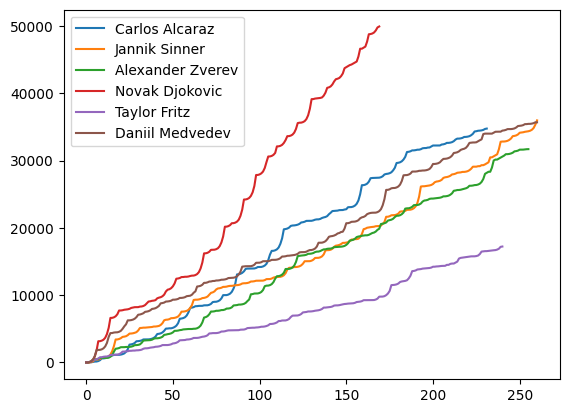

In [31]:
plt.plot(strenghtModel.ratings_story['Carlos Alcaraz']["ratings"], label='Carlos Alcaraz')
plt.plot(strenghtModel.ratings_story['Jannik Sinner']["ratings"], label='Jannik Sinner')
plt.plot(strenghtModel.ratings_story['Alexander Zverev']["ratings"], label='Alexander Zverev')
plt.plot(strenghtModel.ratings_story['Novak Djokovic']["ratings"], label='Novak Djokovic')
plt.plot(strenghtModel.ratings_story['Taylor Fritz']["ratings"], label='Taylor Fritz')
plt.plot(strenghtModel.ratings_story['Daniil Medvedev']["ratings"], label='Daniil Medvedev')
plt.legend()